In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# Objectif du notebook

Comparer les différentes modélisation possible sur la variable **production Eolienne** :

* SARIMAX avec des données métier en régresseurs exogènes
* SARIMAX sur le signal sans régresseur
* Régression linéaire sur les données métiers comme variables explicatives

**NOTA BENE :** Pour la période 3h, le calcul avec un modèle SARIMAX n'aboutit pas sans données exogènes en paramètre.

# Import du dataset original

In [2]:
df = pd.read_csv('./dataset/France_W.csv',
                usecols = ['Dates', 'Eolien'])
df.head(1)

,Dates,Eolien
0,2013-01-06,1368.822222


In [3]:
df['Dates'] = pd.to_datetime(df['Dates'], yearfirst = True)
df.set_index('Dates', inplace = True)

In [4]:
debut = dt.datetime(year = 2013, month = 1, day = 1)
fin = dt.datetime(year = 2020, month = 1, day = 1)

# Conversion en taux de charge pour annuler l'évolution dans le temps

In [5]:
capa = pd.read_csv('./datasource/capacite_eolien_FR.csv',
                  usecols = ['Dates', 'Capa_eol'])
capa['Dates'] = pd.to_datetime(capa['Dates'], format = '%Y/%m/%d %H:%M:%S', yearfirst = True)
capa.set_index('Dates', inplace = True)

In [6]:
capa = capa.resample('W').mean()

In [7]:
df = pd.concat([df, capa], axis = 1)
df['TCH_eol'] = df['Eolien'] / df['Capa_eol']
df

,Eolien,Capa_eol,TCH_eol
Dates,,,
2013-01-06,1368.822222,7523.333333,0.181944
2013-01-13,835.172619,7534.857143,0.110841
2013-01-20,1547.663690,7547.428571,0.205058
2013-01-27,1679.458333,7558.857143,0.222184
2013-02-03,4031.505952,7571.285714,0.532473
...,...,...,...
2021-10-03,5399.238095,18471.142857,0.292307
2021-10-10,4493.095238,18493.285714,0.242958
2021-10-17,1803.785714,18515.571429,0.097420


''

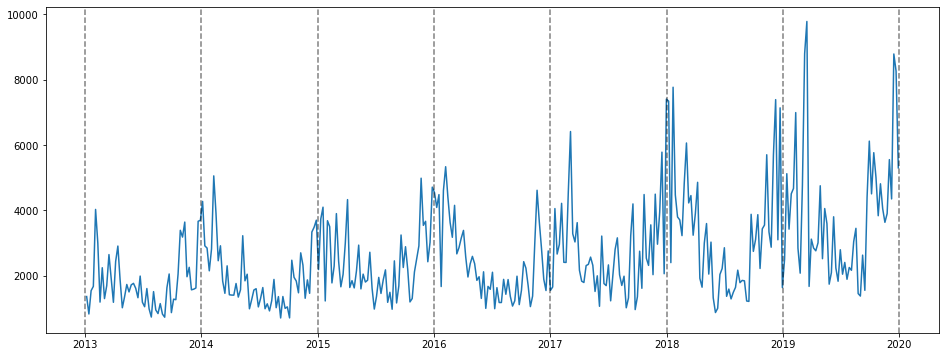

In [8]:
plt.figure(figsize=(16, 6))
plt.plot(df['Eolien'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

''

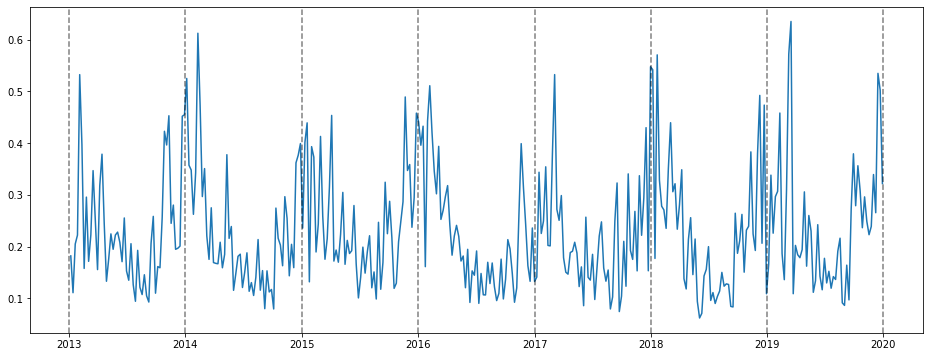

In [9]:
plt.figure(figsize=(16, 6))
plt.plot(df['TCH_eol'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

### Test de stationnarité

In [10]:
# la 2ème valeur donne la p_value (stationnaire si < 5%)
sm.tsa.stattools.adfuller(df['TCH_eol'])

(-6.616734239344638,
 6.180331419099945e-09,
 18,
 442,
 {'1%': -3.445231637930579,
  '5%': -2.8681012763264233,
  '10%': -2.5702649212751583},
 -819.5945763163404)

### Coéfficients SARIMAX et saisonnalités

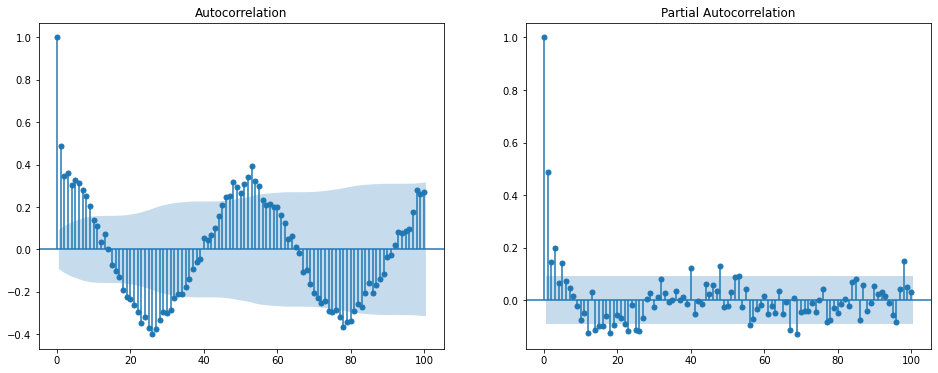

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
plot_acf(df['TCH_eol'], lags = 100, ax=ax1)
plot_pacf(df['TCH_eol'], lags = 100, ax=ax2)
plt.show()

**Saisonnalités :**
* 6 mois

# Jeux d'entrainement et de test

In [12]:
df_train = df[(df.index >= debut) & (df.index < fin)]
df_test = df[df.index >= fin]

In [13]:
fenetre = df_test.shape[0]

In [14]:
indice = df_test.index

In [15]:
bilan = df_test

# Paramètres SARIMAX

In [16]:
ordre = (2,0,0)
saison = (1,0,0,26)

# Régresseurs exogènes : données métier

In [17]:
exog = pd.read_csv('./exog/exog_W_FR.csv', sep = ';',
                    usecols = ['Dates', 'Vent', 'Humidite', 'Pluie_eol', 'Temperature_eol', 'Diff_pression'])
exog.head(1)

,Dates,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression
0,2013-01-06,3.280828,89.401039,0.107481,7.408049,-1316.679846


In [18]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [19]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [20]:
model_exog = sm.tsa.SARIMAX(df_train['TCH_eol'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [21]:
result_exog = model_exog.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
result_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  365
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 26)   Log Likelihood                 775.250
Date:                            Wed, 04 May 2022   AIC                          -1532.499
Time:                                    10:33:18   BIC                          -1497.400
Sample:                                         0   HQIC                         -1518.551
                                            - 365                                         
Covariance Type:                           approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1143      0.002     49.781      0.000       0.110       0.119
x2             0.0020      0.000      4.947      0.000       0.001       0.003
x3            -0.0344      0.012     -2.902      0.004      -0.058      -0.011
x4            -0.0030      0.000     -6.812      0.000      -0.004      -0.002
x5             0.0002   2.71e-05      9.053      0.000       0.000       0.000
ar.L1          0.2559      0.056      4.555      0.000       0.146       0.366
ar.L2          0.0994      0.056      1.788      0.074      -0.010       0.208
ar.S.L26      -0.1026      0.060     -1.724      0.085      -0.219       0.014
sigma2         0.0008   6.57e-05     12.653      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 0.77
Prob(Q):                              0.61   Prob(JB):                         0.68
Heteroskedasticity (H):               0.97   Skew:                             0.09
Prob(H) (two-sided):                  0.87   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [23]:
predict_exog = result_exog.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [24]:
predict_exog = pd.DataFrame(predict_exog, index = indice, columns = ['Eol_p_exog'])

In [25]:
bilan = pd.concat([bilan, predict_exog], axis = 1)

### Erreur absolue

In [26]:
bilan['Err_exog'] = np.abs(bilan['Eol_p_exog'] - bilan['TCH_eol'])
bilan.describe()

,Eolien,Capa_eol,TCH_eol,Eol_p_exog,Err_exog
count,96.000000,96.000000,96.000000,96.000000,96.000000
mean,4262.502542,17514.919643,0.244680,0.228030,0.092465
std,2102.921838,604.024615,0.123614,0.110141,0.076891
min,1114.985119,16497.285714,0.064600,0.041516,0.001684
25%,2559.627232,17000.571429,0.148793,0.153734,0.031452
50%,3868.683036,17503.071429,0.223490,0.205002,0.064717
75%,5656.082589,18029.357143,0.319389,0.272561,0.131641
max,9618.232143,18560.142857,0.578540,0.600913,0.357143


# Sans régresseur

### SARIMAX

In [27]:
model_noreg = sm.tsa.SARIMAX(df_train['TCH_eol'].values,
                       # exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [28]:
result_noreg = model_noreg.fit(low_memory=True)

In [29]:
result_noreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  365
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 26)   Log Likelihood                 301.702
Date:                            Wed, 04 May 2022   AIC                           -595.403
Time:                                    10:33:19   BIC                           -579.804
Sample:                                         0   HQIC                          -589.204
                                            - 365                                         
Covariance Type:                           approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6137      0.050     12.393      0.000       0.517       0.711
ar.L2          0.3240      0.050      6.459      0.000       0.226       0.422
ar.S.L26      -0.0487      0.056     -0.874      0.382      -0.158       0.061
sigma2         0.0111      0.001     13.509      0.000       0.010       0.013
===================================================================================
Ljung-Box (L1) (Q):                   6.22   Jarque-Bera (JB):                37.42
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                            -0.00
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [30]:
predict_noreg = result_noreg.predict(start = 1 ,
                               end = fenetre,
                               # exog = exog_test.values
                            )

In [31]:
predict_noreg = pd.DataFrame(predict_noreg, index = indice, columns = ['Eol_p_noreg'])

In [32]:
bilan = pd.concat([bilan, predict_noreg], axis = 1)

### Erreur absolue

In [33]:
bilan['Err_noreg'] = np.abs(bilan['Eol_p_noreg'] - bilan['TCH_eol'])
bilan.describe()

,Eolien,Capa_eol,TCH_eol,Eol_p_exog,Err_exog,Eol_p_noreg,Err_noreg
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,4262.502542,17514.919643,0.244680,0.228030,0.092465,0.209392,0.089782
std,2102.921838,604.024615,0.123614,0.110141,0.076891,0.094858,0.082593
min,1114.985119,16497.285714,0.064600,0.041516,0.001684,0.082713,0.000345
25%,2559.627232,17000.571429,0.148793,0.153734,0.031452,0.145586,0.026142
50%,3868.683036,17503.071429,0.223490,0.205002,0.064717,0.184206,0.059989
75%,5656.082589,18029.357143,0.319389,0.272561,0.131641,0.246151,0.135344
max,9618.232143,18560.142857,0.578540,0.600913,0.357143,0.488436,0.361096


# Régression linéaire avec Régresseurs exogènes : données métier 

In [34]:
exog = pd.read_csv('./exog/exog_W_FR.csv', sep = ';',
                   usecols = ['Dates', 'Vent', 'Humidite', 'Pluie_eol', 'Temperature_eol', 'Diff_pression'])
exog.head(1)

,Dates,Vent,Humidite,Pluie_eol,Temperature_eol,Diff_pression
0,2013-01-06,3.280828,89.401039,0.107481,7.408049,-1316.679846


In [35]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [36]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [37]:
LinReg = LinearRegression()
LinReg.fit(exog_train, df_train['TCH_eol'])
predict_lr = LinReg.predict(exog_test)

In [38]:
predict_lr = pd.DataFrame(predict_lr, index = indice, columns = ['Eol_p_LinReg'])

In [39]:
bilan = pd.concat([bilan, predict_lr], axis = 1)

### Erreur absolue

In [40]:
bilan['Err_LinReg'] = np.abs(bilan['Eol_p_LinReg'] - bilan['TCH_eol'])
bilan.describe()

,Eolien,Capa_eol,TCH_eol,Eol_p_exog,Err_exog,Eol_p_noreg,Err_noreg,Eol_p_LinReg,Err_LinReg
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,4262.502542,17514.919643,0.244680,0.228030,0.092465,0.209392,0.089782,0.239360,0.028866
std,2102.921838,604.024615,0.123614,0.110141,0.076891,0.094858,0.082593,0.116777,0.021708
min,1114.985119,16497.285714,0.064600,0.041516,0.001684,0.082713,0.000345,0.039931,0.000200
25%,2559.627232,17000.571429,0.148793,0.153734,0.031452,0.145586,0.026142,0.151544,0.011106
50%,3868.683036,17503.071429,0.223490,0.205002,0.064717,0.184206,0.059989,0.224806,0.022893
75%,5656.082589,18029.357143,0.319389,0.272561,0.131641,0.246151,0.135344,0.303151,0.039249
max,9618.232143,18560.142857,0.578540,0.600913,0.357143,0.488436,0.361096,0.611473,0.099778


# Calcul de la prediction : TCH x Capacité

In [41]:
bilan['Eol_p_exog'] = bilan['Eol_p_exog'] * bilan['Capa_eol']
bilan['Err_exog'] = bilan['Err_exog'] * bilan['Capa_eol']
bilan['Eol_p_noreg'] = bilan['Eol_p_noreg'] * bilan['Capa_eol']
bilan['Err_noreg'] = bilan['Err_noreg'] * bilan['Capa_eol']
bilan['Eol_p_LinReg'] = bilan['Eol_p_LinReg'] * bilan['Capa_eol']
bilan['Err_LinReg'] = bilan['Err_LinReg'] * bilan['Capa_eol']
bilan.describe()

,Eolien,Capa_eol,TCH_eol,Eol_p_exog,Err_exog,Eol_p_noreg,Err_noreg,Eol_p_LinReg,Err_LinReg
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,4262.502542,17514.919643,0.244680,3977.994962,1609.372077,3657.068589,1562.278170,4173.982024,505.300583
std,2102.921838,604.024615,0.123614,1901.559137,1319.933638,1644.688324,1412.824615,1986.638974,381.195339
min,1114.985119,16497.285714,0.064600,765.894296,30.236464,1415.342447,6.241130,670.607892,3.421527
25%,2559.627232,17000.571429,0.148793,2680.515740,571.496119,2547.206499,469.107730,2630.878241,188.589117
50%,3868.683036,17503.071429,0.223490,3509.404699,1180.255555,3204.996469,1060.330986,3944.126353,402.918591
75%,5656.082589,18029.357143,0.319389,4826.926371,2318.416246,4342.160503,2309.404609,5122.217165,699.704105
max,9618.232143,18560.142857,0.578540,10628.861355,5953.108313,8650.271604,6019.002907,10165.731433,1771.515139


# Visualisation réel vs prédictions

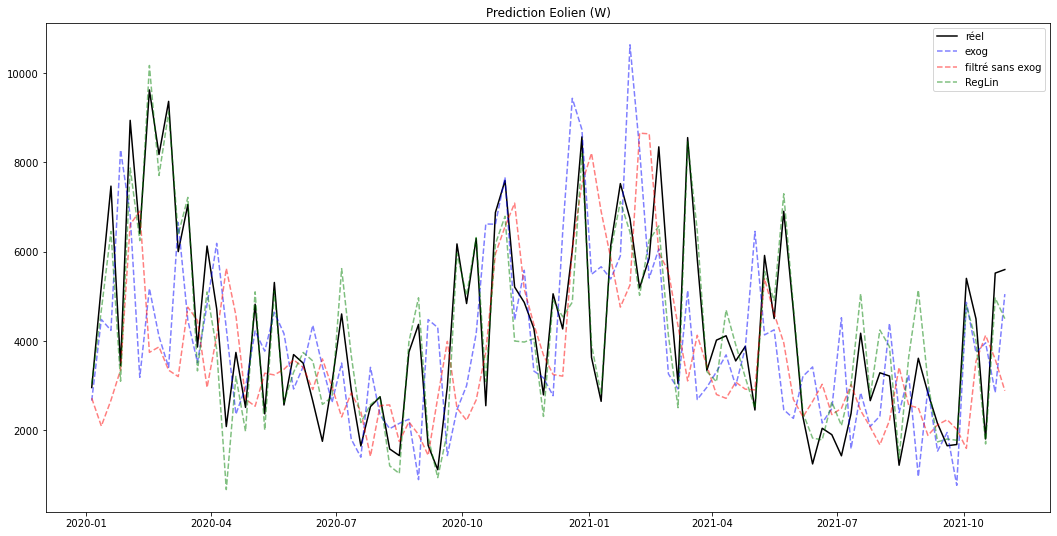

In [42]:
plt.figure(figsize=(18,9))
#plt.plot(df_train['Eolien'].resample('W').mean(), color = 'k')
plt.plot(bilan['Eolien'].resample('W').mean(), color = 'k', label = 'réel')
plt.plot(bilan['Eol_p_exog'].resample('W').mean(), color = 'b', linestyle = '--', alpha = 0.5, label = 'exog')
plt.plot(bilan['Eol_p_noreg'].resample('W').mean(), color = 'r', linestyle = '--', alpha = 0.5, label = 'filtré sans exog')
plt.plot(bilan['Eol_p_LinReg'].resample('W').mean(), color = 'g', linestyle = '--', alpha = 0.5, label = 'RegLin')
plt.legend(loc = 'upper right')
plt.title('Prediction Eolien (W)')
plt.savefig('./results/W/pred_eolien_W.png');

# Synthèse des erreurs

In [43]:
erreur = bilan[['Err_exog',
       'Err_noreg',
       'Err_LinReg'
      ]].describe()
erreur

,Err_exog,Err_noreg,Err_LinReg
count,96.000000,96.000000,96.000000
mean,1609.372077,1562.278170,505.300583
std,1319.933638,1412.824615,381.195339
min,30.236464,6.241130,3.421527
25%,571.496119,469.107730,188.589117
50%,1180.255555,1060.330986,402.918591
75%,2318.416246,2309.404609,699.704105
max,5953.108313,6019.002907,1771.515139


In [44]:
exog_test.columns

Index(['Vent', 'Humidite', 'Pluie_eol', 'Temperature_eol', 'Diff_pression'], dtype='object')

In [45]:
LinReg.coef_

array([ 0.11768117,  0.00234376, -0.03500004, -0.00038949, -0.00016759])

In [46]:
bilan.to_csv('./results/W/bilan_eolien_W.csv', sep = ';')
erreur.to_csv('./results/W/erreur_eolien_W.csv', sep = ';')